In [1]:
!apt-get install -y libgl1-mesa-glx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [18]:
!pip install ipywidgets

     |████████████████████████████████| 121 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 81.7 MB/s eta 0:00:01


In [1]:
import ipywidgets

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
from torchvision import transforms
import os
from pathlib import Path
import cv2
from torch.utils.data import Dataset, DataLoader

In [3]:
train_data = pd.read_csv('./input/data/train/train.csv')
eval_data = pd.read_csv('./input/data/eval/info.csv')
train_img_path = './input/data/train/images/'
eval_img_path = './input/data/eval/images/'

In [4]:
train_data

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [5]:
cpy_train_data = train_data.copy()

In [6]:
# class 판별 기준
# 1. mask 착용 여부 : image file name으로 판별
# 2. 성별 : female, male
# 3. 나이 : < 30, 30 <= x < 60, >= 60


# labeling
# filename, gender, age로 class를 특정해 return한다.
# filename : image file의 이름. image file의 이름이 image의 마스크 착용 여부를 기록하고 있다.
# gender : 성별, Male or Female
# age : 나이, 30세 미만, 30~60세, 60세 이상
def labeling(filename, gender, age):
    
    # classes : Mask상태, Gender, Age의 tuple을 key로 하고 class num을 반환
    classes = dict()
    cls = 0
    for category_filename in ['wear', 'incorrect', 'notWear']:
        for category_gender in ['male', 'female']:
            for category_age in ['under30', 'between30and60', 'over60']:
                classes[category_filename, category_gender, category_age] = cls
                cls = cls + 1
                
    # filename을 통해 Mask상태 지정
    mask = ('wear' if filename[:4] == 'mask' else 'notWear' if filename[:6] == 'normal' else 'incorrect')
    
    # gender는 이미 Male or Female
    
    # age를 통해 age 상태 지정
    age = ('under30' if age < 30 else 'between30and60' if 30 <= age < 60 else 'over60')    
    
    
    return classes[mask, gender, age]
########################################
########################################

X = []
y = []

for i in range(cpy_train_data.shape[0]):
    
    # 각 폴더에 해당하는 gender와 age를 지정하고,
    # 내부 image file의 이름을 image_list로 저장한다.
    folder_path = train_img_path + cpy_train_data.loc[i, 'path'] + '/'
    gender = cpy_train_data.loc[i, 'gender']
    age = cpy_train_data.loc[i, 'age']
    image_list = os.listdir(folder_path)
    
    # image file이 window 형식(앞에 ._ 안붙음)이고 image file이면 labeling 한다.
    # 폴더 내 파일이름, class를 각각 list로 저장한다. (X, y로 만들예정)
    
    for filename in image_list:
        if filename[0] != '.':
            X.append(folder_path + filename)
            y.append(labeling(filename, gender, age))
    

In [7]:
train = pd.DataFrame()

In [8]:
train['image'] = X
train['target'] = y
train

,image,target
0,./input/data/train/images/000001_female_Asian_...,4
1,./input/data/train/images/000001_female_Asian_...,4
2,./input/data/train/images/000001_female_Asian_...,10
3,./input/data/train/images/000001_female_Asian_...,4
4,./input/data/train/images/000001_female_Asian_...,4
...,...,...
18895,./input/data/train/images/006959_male_Asian_19...,6
18896,./input/data/train/images/006959_male_Asian_19...,0
18897,./input/data/train/images/006959_male_Asian_19...,0
18898,./input/data/train/images/006959_male_Asian_19...,12


In [9]:
img = train.loc[0, 'image']
sample = Image.open(img)

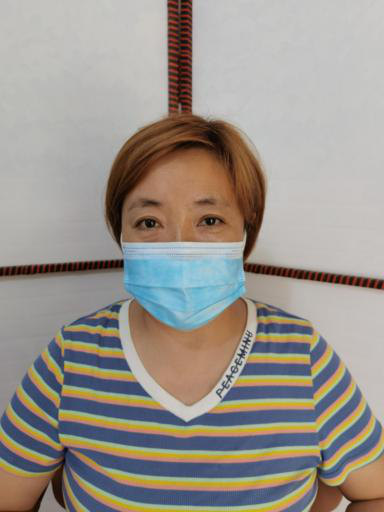

In [10]:
sample

In [11]:
sample.size

(384, 512)

In [12]:
img = train.loc[0,'image']
img = cv2.imread(img)

In [13]:
img

array([[[189, 191, 192],
        [189, 191, 192],
        [189, 191, 192],
        ...,
        [201, 203, 204],
        [201, 203, 204],
        [201, 203, 204]],

       [[189, 191, 192],
        [189, 191, 192],
        [189, 191, 192],
        ...,
        [201, 203, 204],
        [201, 203, 204],
        [201, 203, 204]],

       [[189, 191, 192],
        [189, 191, 192],
        [189, 191, 192],
        ...,
        [200, 202, 203],
        [201, 203, 204],
        [201, 203, 204]],

       ...,

       [[ 52,  80, 127],
        [ 51,  79, 126],
        [ 51,  79, 126],
        ...,
        [ 66, 101, 151],
        [ 69, 103, 156],
        [ 71, 105, 158]],

       [[ 35,  63, 110],
        [ 34,  62, 109],
        [ 34,  62, 109],
        ...,
        [ 67, 102, 152],
        [ 69, 103, 156],
        [ 70, 107, 159]],

       [[ 11,  39,  86],
        [ 11,  39,  86],
        [ 11,  39,  86],
        ...,
        [ 67, 102, 152],
        [ 68, 105, 157],
        [ 70, 107, 159]]

In [14]:
class MaskDataset(Dataset):
    def __init__(self, df, transform=None, train=True):
        super().__init__()
        self.df = df
        self.X = self.df.image
        self.y = self.df.target
        self.transform = transform
        self.train = train
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = cv2.imread(self.X[idx])
        X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            X = self.transform(X)
        if self.train:
            y = self.y[idx]
        
        return torch.tensor(X), torch.tensor(y)
        

In [15]:
datas = MaskDataset(train,
                   transform=transforms.Compose([
                       transforms.ToPILImage(),
                       transforms.ToTensor()]))

In [16]:
dl = DataLoader(datas, batch_size = 128, drop_last = True)

In [17]:
model = torchvision.models.resnet18(pretrained=True, progress=False)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
model.fc = torch.nn.Linear(in_features=512, out_features=18, bias=True)

In [19]:
for param in model.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)
model.to(device)

LEARNING_RATE = 0.001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 30 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

cuda:0


In [21]:
### 학습 코드 시작


for epoch in range(NUM_EPOCH):
    running_loss = 0.
    running_acc = 0.
    for i, (inputs, labels) in enumerate(dl):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)     
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0) # 한 Batch에서의 loss 값 저장
        running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장
    
        if i % 100 == 0:
            print(i)
            print('preds: ', preds)
            print('labels :', labels)
    epoch_loss = running_loss / int(len(dl.dataset) / dl.batch_size)
    epoch_acc = running_acc / int(len(dl.dataset) / dl.batch_size)

    print(f"현재 epoch-{epoch}의 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")

<ipython-input-14-17604ca85f92>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X), torch.tensor(y)


0
preds:  tensor([ 7,  8,  7,  8,  8,  7,  8,  8,  8,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8, 15,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  9,  8,  7, 15,  7, 15,  8,  8,  8,  8,  8,  8,  2,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8, 15,  8,  8,  8,  8, 15,  8, 15, 15, 15,  7, 15, 15, 15,  8,  7, 15,
         7,  7,  8,  2,  2,  8,  2,  2,  2,  8,  2,  8,  8,  7,  8,  8,  8,  8,
         7,  8], device='cuda:0')
labels : tensor([ 4,  4, 10,  4,  4, 16,  4,  4,  4, 10,  4,  4, 16,  4,  1,  1,  7,  1,
         1, 13,  1,  4,  4, 10,  4,  4, 16,  4,  4,  4, 10,  4,  4, 16,  4,  4,
         4, 10,  4,  4, 16,  4,  4,  4, 10,  4,  4, 16,  4,  4,  4, 10,  4,  4,
        16,  4,  4,  4, 10,  4,  4, 16,  4,  1,  1,  7,  1,  1, 13,  1,  4,  4,
        10,  4,  4, 16,  4,  1,  1,  7,  1,  1, 13,  1,  4,  4, 10,

In [23]:
torch.save(model.state_dict(), os.path.join('/opt/ml/input/data', "model.pt"))

## 3. Inference

In [24]:
test_dir = '/opt/ml/input/data/eval'
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')





#################################
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)
#################################



# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    transforms.Resize((512, 384), Image.BILINEAR),
    transforms.ToTensor(),
])

###########################################
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')

model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for i, images in enumerate(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
    if i % 100 == 0:
        print(i)
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
test inference is done!
